## part1: 数据处理

In [9]:
# Credit: sentdex
# link: https://pythonprogramming.net/3d-convolutional-neural-network-machine-learning-tutorial/
import os
import pandas as pd

data_dir = 'data/demo/nodule/'
patients = os.listdir(data_dir)
labels_df = pd.read_csv('data/demo/train_data.csv',index_col=0)

labels_df.head()

,lable
name,
candidate1,1
candidate2,0
candidate3,1
candidate4,1
candidate5,0


In [10]:
len(patients)

465

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import math

/home/vivi/anaconda3/envs/3dunet/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.


[[[170 169 162 ...   7   2   3]
  [174 170 170 ...  59  20  14]
  [183 169 166 ... 146  67  19]
  ...
  [195 189 187 ...  24  28  27]
  [194 190 191 ...  17  24  33]
  [192 188 191 ...  20  25  27]]

 [[169 167 164 ...  12   5   2]
  [168 164 166 ...  53  16   5]
  [177 167 167 ... 145  75  16]
  ...
  [191 184 191 ...  21  25  26]
  [192 191 195 ...  19  24  24]
  [191 193 198 ...  17  21  23]]

 [[170 169 165 ...  14   5   1]
  [172 169 165 ...  50  10   2]
  [170 165 168 ... 145  78  22]
  ...
  [193 190 188 ...  27  25  23]
  [192 189 191 ...  25  23  20]
  [187 190 192 ...  25  25  22]]

 ...

 [[177 181 178 ...   5   3   4]
  [174 180 181 ...   4   2   4]
  [172 170 171 ...  10  11  14]
  ...
  [192 189 192 ... 185 187 189]
  [190 192 195 ... 186 187 185]
  [193 196 191 ... 189 185 185]]

 [[184 183 178 ...   3   2   2]
  [178 181 181 ...   2   4   3]
  [171 169 170 ...   7  13  10]
  ...
  [191 193 194 ... 182 182 187]
  [191 192 195 ... 185 182 182]
  [195 193 191 ... 188 184 1

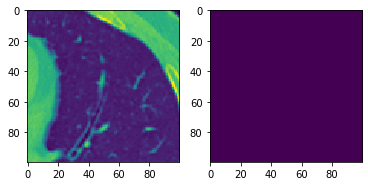

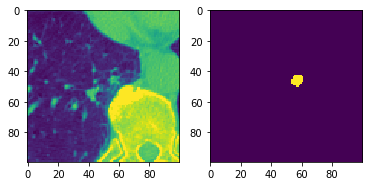

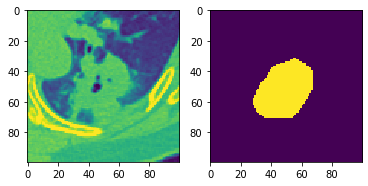

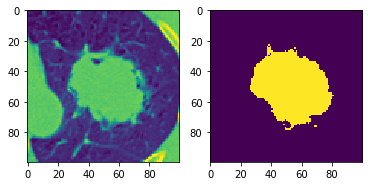

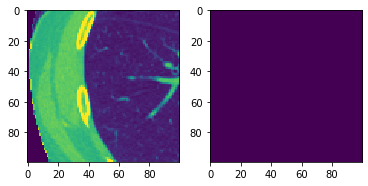

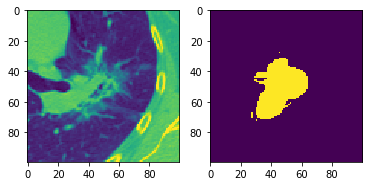

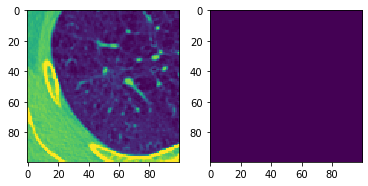

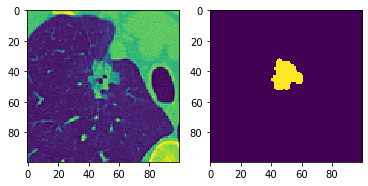

In [12]:
# 验证数据集的大小
for patient in patients[:8]:
    patient_name = patient[0:-4]
    label = labels_df.get_value(patient_name, 'lable')
    path = data_dir + patient
    # a couple great 1-liners from: https://www.kaggle.com/gzuidhof/data-science-bowl-2017/full-preprocessing-tutorial
    scan = np.load(path)
    print(scan['voxel'],label)
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(scan['voxel'][37])
    plt.subplot(1,2,2)
    plt.imshow(scan['seg'][37])

In [61]:
# 将数据集存储在muchdata.npy中：
much_data = []
for num, patient in enumerate(patients):
    patient_name = patient[0:-4]
    label = labels_df.get_value(patient_name, 'lable')
    path = data_dir + patient
    img_data = np.load(path)
    voxel = img_data['voxel'].astype(np.int32)
#     seg = img_data['seg']
#     plt.imshow(voxel[50])
#     print(label)
    much_data.append([voxel,label])
    
np.save('muchdata', much_data)

 ## part2: 神经网络模块
 some codes work below, follow the tutorial: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.device_count() )

True
2


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import math

### 怎么把数据我现在的数据变成需要的数据？

- 先要理清思路，现在的数据长什么样子?
source https://blog.csdn.net/DaVinciL/article/details/78793067 介绍了CIFAR数据集
- 现在的网络每层的输入输出是什么样子？

### train part:

In [26]:
import torch.nn as nn
import torch.nn.functional as F
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device=torch.device("cpu")

In [27]:
device

device(type='cuda', index=0)

### Network-1

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # average pool, kernel:2 stride:2
        self.avg = nn.AvgPool3d(2, 2) # 50x50
        # input_channel:1; output_channel(#filter):32; kernel_size: 3
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=32, kernel_size=3)
        # maxpool: kernel: 2; stride: 2
        self.pool1 = nn.MaxPool3d(2, 2)
        # input_channel:10; output_channel(#filter):20; kernel_size: 10*10
        self.conv2 = nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv3 = nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3)
        self.pool2 = nn.MaxPool3d(3, 3)
        '''modify - 01'''
        # Bottleneck features:
#         self.conv4 = nn.Conv3d(in_channels=128, out_channels=16, kernel_size=3) # 1x1x1, 16
#         self.conv5 = nn.Conv3d(in_channels=16, out_channels=1, kernel_size=3, padding=1)
#         self.conv6 = nn.Conv3d(in_channels=1, out_channels=1, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128*3*3*3, 128*3*3)
        self.fc2 = nn.Linear(128*3*3, 128*3)
        self.fc3 = nn.Linear(128*3, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 2)

    def forward(self, x):
        x = self.avg(x) # 50x50x50 1
        x = self.pool1(F.relu(self.conv1(x))) # 48x48x48, 32 -> 24x24x24, 32
        x = self.pool1(F.relu(self.conv2(x))) # 22x22x22, 64 -> 11x11x11, 64
        x = self.pool2(F.relu(self.conv3(x))) # 9x9x9, 128 -> 3x3x3, 128
        '''modify - 01'''
#         x = F.relu(self.conv4(x))
#         x = F.sigmoid(self.conv5(x))
#         x = self.conv6(x)
        x = x.view(-1, 128*3*3*3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.softmax(self.fc7(x)) # 变成概率形式
        return x


net = Net()
net = net.to(device)

### Network-2

In [28]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        # average pool, kernel:2 stride:2
        self.avg = nn.AvgPool3d(2, 2) # 50x50
        # input_channel:1; output_channel(#filter):32; kernel_size: 3
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=32, kernel_size=3)
        # maxpool: kernel: 2; stride: 2
        self.pool1 = nn.MaxPool3d(2, 2)
        # input_channel:10; output_channel(#filter):20; kernel_size: 10*10
        self.conv2 = nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv3 = nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3)
        self.pool2 = nn.MaxPool3d(3, 3)
        '''modify - 01'''
        # Bottleneck features:
        self.conv4 = nn.Conv3d(in_channels=128, out_channels=64, kernel_size=3) # 1x1x1, 16
        self.conv5 = nn.Conv3d(in_channels=16, out_channels=1, kernel_size=3, padding=1)
#         self.conv6 = nn.Conv3d(in_channels=1, out_channels=1, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64, 48)
        self.fc2 = nn.Linear(48, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 8)
        self.fc5 = nn.Linear(8, 2)


    def forward(self, x):
        x = self.avg(x) # 50x50x50 1
        x = self.pool1(F.relu(self.conv1(x))) # 48x48x48, 32 -> 24x24x24, 32
        x = self.pool1(F.relu(self.conv2(x))) # 22x22x22, 64 -> 11x11x11, 64
        x = self.pool2(F.relu(self.conv3(x))) # 9x9x9, 128 -> 3x3x3, 128
        '''modify - 01'''
        x = F.relu(self.conv4(x)) # 1x1x1, 16 
        x = x.view(-1, 64)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.softmax(self.fc5(x))

#         x = F.sigmoid(self.conv5(x))
#         x = self.conv6(x)

        return x


net = Net()
net = net.to(device)

In [42]:
import torch.optim as optim

criterion = nn.NLLLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [30]:
# use np.load to import data, devide dataset into 2 parts: train_data & validation_data:
# credit: cheez & Matthew Kerian
# link: https://stackoverflow.com/questions/55890813/how-to-fix-object-arrays-cannot-be-loaded-when-allow-pickle-false-for-imdb-loa/56243777
'''use older to successfully load the data:'''
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

data_ineed = np.load('muchdata.npy')

# restore np.load for future normal usage
np.load = np_load_old

# If you are working with the basic sample data, use maybe 2 instead of 100 here... you don't have enough data to really do this
train_data = data_ineed[:-60]
validation_data = data_ineed[-60:]

In [44]:
for epoch in range(4):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_data, 0):
        # get the inputs; data is a list of [inputs, labels]
        # inputs: tensor(100*(100*100)), label
        inputs_numpy, labels = data
        inputs = torch.from_numpy(inputs_numpy)
        inputs = inputs.unsqueeze(0)
        inputs = inputs.unsqueeze(0)
        inputs = inputs.float()
        inputs = inputs.to(device)
        labels = torch.from_numpy(np.asarray(labels)).float()
        labels = labels.long() #credit: ptrblck; link: https://discuss.pytorch.org/t/runtimeerror-expected-object-of-scalar-type-long-but-got-scalar-type-float-when-using-crossentropyloss/30542/4
        labels = labels.unsqueeze(0)

        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        outputs = torch.log(outputs) # 为了放进损失函数 NLLLoss() 中：
        
#         outputs = outputs.squeeze(0)
#         outputs = outputs.squeeze(0)
#         outputs = outputs.squeeze(0)
#         outputs = outputs.squeeze(0)
#         outputs = outputs.squeeze(0)
#         poss = outputs.detach().numpy()
#         float(poss)
#         pred = np.array([[1-float(poss),float(poss)]])
#         pred = torch.from_numpy(pred)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
#         if i==1:
#             break
            
        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

/home/vivi/anaconda3/envs/3dunet/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[1,   100] loss: 0.702
[1,   200] loss: 0.689
[1,   300] loss: 0.694
[1,   400] loss: 0.684
[2,   100] loss: 0.701
[2,   200] loss: 0.689
[2,   300] loss: 0.694
[2,   400] loss: 0.684
[3,   100] loss: 0.701
[3,   200] loss: 0.689
[3,   300] loss: 0.694
[3,   400] loss: 0.684
[4,   100] loss: 0.701
[4,   200] loss: 0.689
[4,   300] loss: 0.694
[4,   400] loss: 0.684
Finished Training


In [46]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### test part

In [47]:
PATH = './cifar_net.pth'
net = Net()
net.load_state_dict(torch.load(PATH))
net = net.to(device)

In [48]:
predict_value = []
true_value = []
for i, data in enumerate(validation_data, 0):
    inputs_numpy, labels = data
    inputs = torch.from_numpy(inputs_numpy)
    inputs = inputs.unsqueeze(0)
    inputs = inputs.unsqueeze(0)
    inputs = inputs.float()
    inputs = inputs.cuda()
    labels = torch.from_numpy(np.asarray(labels)).float()
    labels = labels.long() #credit: ptrblck; link: https://discuss.pytorch.org/t/runtimeerror-expected-object-of-scalar-type-long-but-got-scalar-type-float-when-using-crossentropyloss/30542/4
    labels = labels.unsqueeze(0)
    labels = labels.cuda()

    outputs = net(inputs)

    outputs = outputs.cpu()
    outputs = outputs.squeeze(0)
    outputs = outputs.detach().numpy()
    predict_value.append(outputs[1])
    
    labels = labels.cpu()
    labels = labels.detach().numpy()
    labels[0]
    true_value.append(labels[0])
    
# ROC-AUC reference: https://www.cnblogs.com/dlml/p/4403482.html
# link: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
from sklearn.metrics import roc_auc_score
roc_auc_score(true_value, predict_value)

/home/vivi/anaconda3/envs/3dunet/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.5